In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import DataSplitter

# Seasonality

In [2]:
def fourierTransform(seq):
    dft_seq = np.fft.fft(seq)
    return pd.Series(dft_seq)

def inverseFourierTransform(seq):
    idft_seq = np.fft.ifft(seq)
    return pd.Series(idft_seq)

In [3]:
np.set_printoptions(precision=2, suppress=True)
df = DataSplitter.getTrainData(60)

# not differenced
passengers = [df[(df["line"] == f"{i+1}A")]["passengersBoarding"].tolist() for i in range(6)]
# differenced
#passengers = [df[(df["line"] == f"{i+1}A")]["passengersBoarding"].diff(periods=1).fillna(0).tolist() for i in range(6)]

passengers_ft = [fourierTransform(passenger_line) for passenger_line in passengers]
nsamples = len(passengers[0])
print('samples', nsamples)

max_magnitude_of_passengers = []
for passenger_line in passengers_ft:
    max_magnitude_of_line = []
    norms = np.abs(passenger_line[:nsamples//2][1:])

    # pick the n largest but not DC
    amount_of_tops = 5
    max_index = np.argsort(norms)[-amount_of_tops::][::-1] + 1
    print(norms[max_index])
    # find the period
    print('periods in hours', 2*np.pi / (np.pi * max_index.values/(nsamples/2)))

    # 0-array except for largest magnitudes
    max_magnitude_of_line = np.zeros(nsamples)
    max_magnitude_of_line[max_index] = norms[max_index]

    # magnitude but where tops are set to 0
    #norms[max_index] = 0
    #max_magnitude_of_line = norms

    max_magnitude_of_passengers.append(max_magnitude_of_line + max_magnitude_of_line[::-1])


samples 16520
826     2.223092e+06
2478    7.366438e+05
118     6.326477e+05
708     5.643986e+05
1       5.366402e+05
dtype: float64
periods in hours [   20.       6.67   140.      23.33 16520.  ]
826     2.254067e+06
118     6.975440e+05
2478    6.550353e+05
708     5.541038e+05
236     4.265191e+05
dtype: float64
periods in hours [ 20.   140.     6.67  23.33  70.  ]
826     1.641207e+06
2478    5.338825e+05
118     4.864336e+05
708     3.804061e+05
236     2.981769e+05
dtype: float64
periods in hours [ 20.     6.67 140.    23.33  70.  ]
826     2.648031e+06
2478    9.967303e+05
118     9.403821e+05
708     7.237295e+05
1652    6.765797e+05
dtype: float64
periods in hours [ 20.     6.67 140.    23.33  10.  ]
826     1.214374e+06
2478    5.520555e+05
118     5.431316e+05
1652    4.282435e+05
236     3.544054e+05
dtype: float64
periods in hours [ 20.     6.67 140.    10.    70.  ]
826     1.875341e+06
2478    1.344114e+06
118     1.103986e+06
1652    8.728505e+05
4130    6.795384e+05
d

c:\Python310\lib\site-packages\matplotlib\cbook\__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


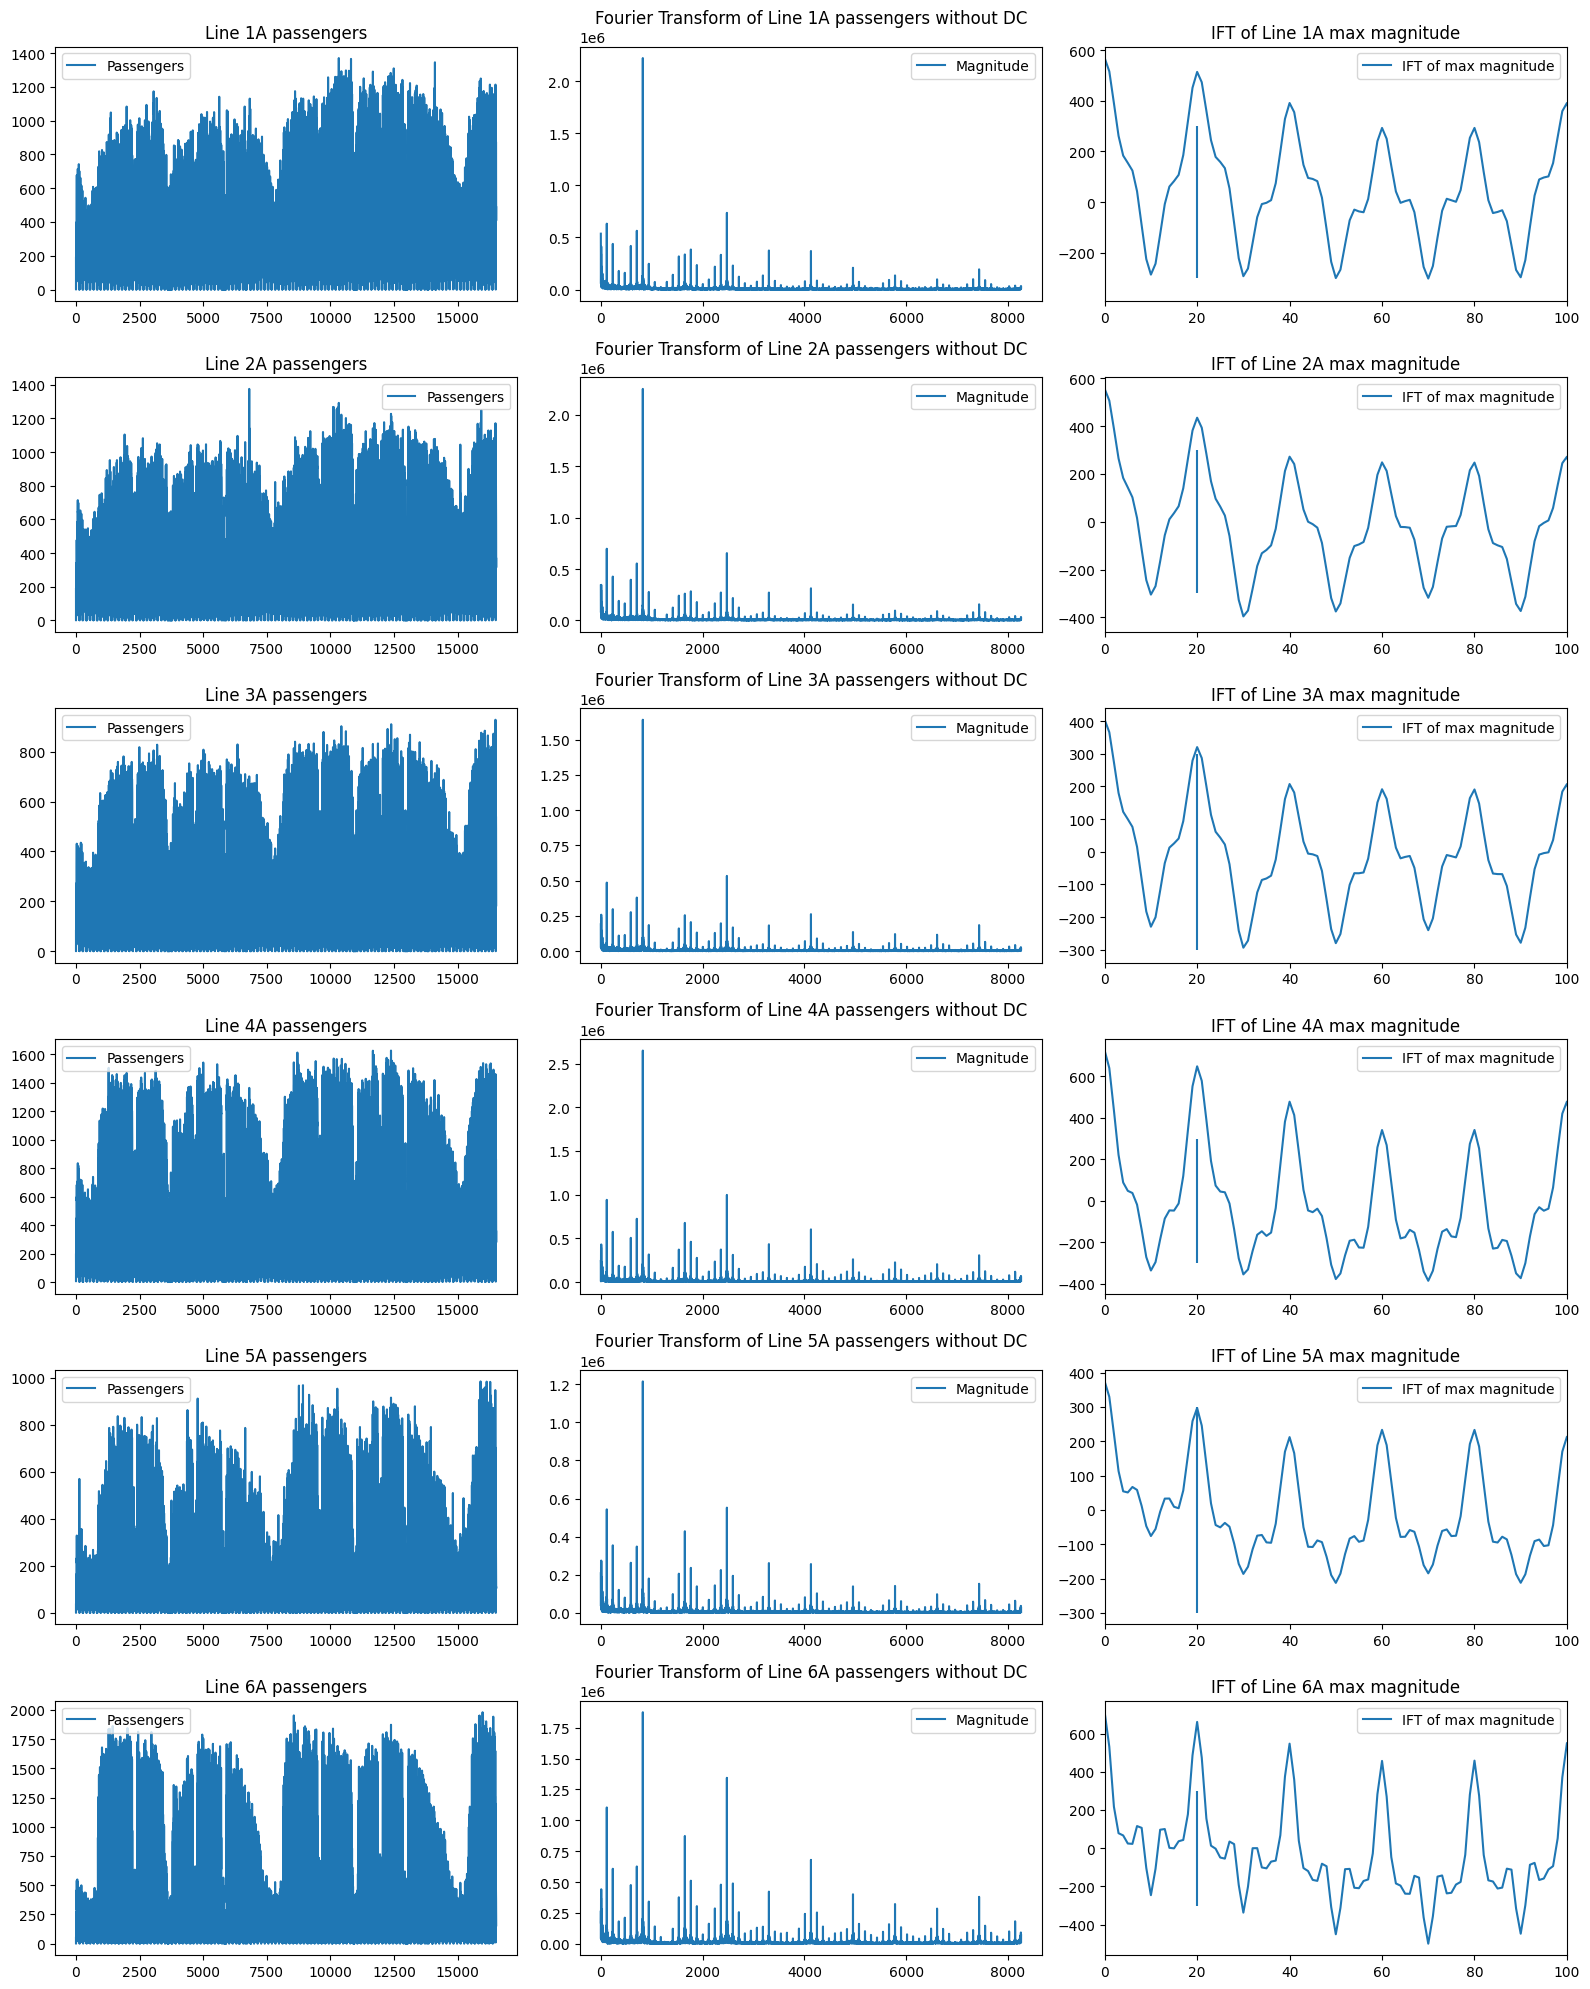

In [4]:
# Create a 3x4 grid of subplots
fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(16, 20))

# Flatten the 2D array of subplots into a 1D array
axes = axes.flatten()

# Plot on each subplot
for i in range(0, 6):
    # plot passenger
    axes[i*3].plot(passengers[i], label=f"Passengers")
    axes[i*3].set_title(f"Line {i+1}A passengers")
    axes[i*3].legend()

    # plot frequency spectrum without DC
    mag = np.abs(passengers_ft[i][1:nsamples//2])
    axes[(i*3)+1].plot(mag, label=f"Magnitude")
    axes[(i*3)+1].set_title(f"Fourier Transform of Line {i+1}A passengers without DC")
    axes[(i*3)+1].legend()

    # plot inverse transform
    #axes[(i*3)+2].plot(inverseFourierTransform(max_magnitude_of_passengers[i][len(max_magnitude_of_passengers)//2:]), label=f"IFT of max magnitude")
    axes[(i*3)+2].plot(inverseFourierTransform(max_magnitude_of_passengers[i]), label=f"IFT of max magnitude")
    axes[(i*3)+2].set_title(f"IFT of Line {i+1}A max magnitude")
    axes[(i*3)+2].legend()
    axes[(i*3)+2].set_xlim([0, 100])
    axes[(i*3)+2].vlines(x=20, ymin=-300, ymax=300)

# Adjust layout to prevent clipping of titles
plt.tight_layout()

# Show the plot
plt.show()

# Trend

In [5]:
df = DataSplitter.getTrainData(60)

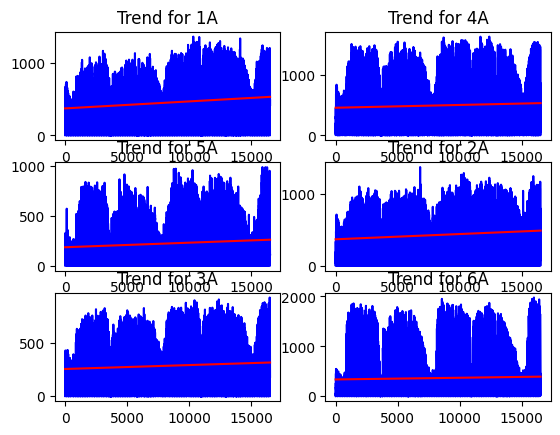

In [6]:
from sktime.transformations.series.detrend import Detrender
from sktime.forecasting.trend import PolynomialTrendForecaster

fig, ax = plt.subplots(3, 2)

for i, line in enumerate(['1A', '2A', '3A', '4A', '5A', '6A']):
    df_subset = df[df['line'] == line]
    df_subset = df_subset.reset_index(drop=True)

    # linear trend
    transformer = Detrender(forecaster=PolynomialTrendForecaster(degree=1))
    y_detrend = transformer.fit_transform(df_subset['passengersBoarding'])

    ax[i % 3, i % 2].plot(y_detrend.index, df_subset['passengersBoarding'], color='blue')
    ax[i % 3, i % 2].plot(y_detrend.index, df_subset['passengersBoarding'] - y_detrend, color='red')
    ax[i % 3, i % 2].set_title(f'Trend for {line}')
plt.show()

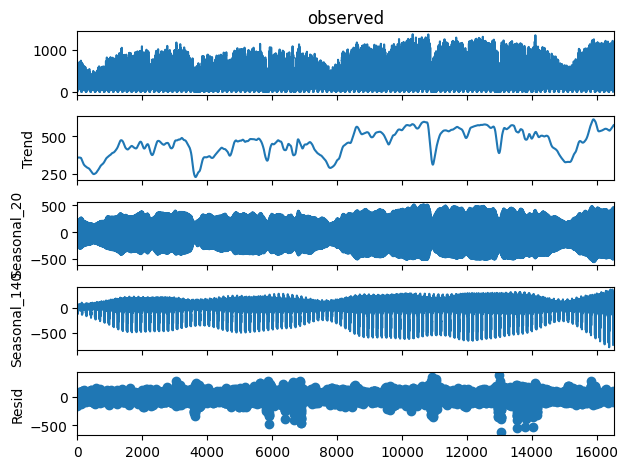

In [7]:
from statsmodels.tsa.seasonal import STL, MSTL

df_subset = df[df['line'] == '1A']
df_subset = df_subset.reset_index(drop=True)
# STL decomposition
#res = STL(df_subset['passengersBoarding'], period=20, seasonal=7, robust=True).fit()
res = MSTL(df_subset['passengersBoarding'], periods=[20, 140]).fit()
plot = res.plot()
plt.show()

# Stationarity

In [9]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tools.sm_exceptions import InterpolationWarning
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings

df15 = DataSplitter.getTrainData(15)
df30 = DataSplitter.getTrainData(30)
df60 = DataSplitter.getTrainData(60)

In [10]:
def adf_test(series, alpha=0.05, hypothesis=False):
    # Extract test statistic and p-value
    test_statistic, p_value, _, _, _, _ = adfuller(series)
    if hypothesis:
        print("H_0: Time Series is not stationary")
        print("H_A: Time Series is stationary")
    if p_value < alpha:
        print(f"p-value: {p_value} < {alpha} (Stationary)")
    if p_value > alpha:
        print(f"p-value: {p_value} > {alpha} (Not Stationary)")
    if p_value == alpha:
        print(f"p-value: {p_value} = {alpha}")
    return test_statistic, p_value

def kpss_test(series, alpha=0.05, hypothesis=False):
    # Extract test statistic and p-value
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=InterpolationWarning)
        test_statistic, p_value, lags, _ = kpss(series)
    if hypothesis:
        print("H_0: Time Series is stationary")
        print("H_A: Time Series is not stationary")
    if p_value < alpha:
        print(f"p-value: {p_value} < {alpha} (Not Stationary)")
    if p_value > alpha:
        print(f"p-value: {p_value} > {alpha} (Stationary)")
    if p_value == alpha:
        print(f"p-value: {p_value} = {alpha}")
    print(f"lags: {lags}")
    return test_statistic, p_value, lags

### ADF tests

In [11]:
adf_results15 = []
adf_results30 = []
adf_results60 = []
for agg_level in [(15, df15, adf_results15), (30, df30, adf_results30), (60, df60, adf_results60)]:
    print(f"{agg_level[0]} min")
    adf_results_temp = []
    for line in ["1A", "2A", "3A", "4A", "5A", "6A"]:
        print(line)
        df_temp = agg_level[1][agg_level[1]['line'] == line].reset_index(drop=True)
        test_statistic, p_value = adf_test(df_temp['passengersBoarding'])
        adf_results_temp.append((line, test_statistic, p_value))
    agg_level[2].append(adf_results_temp)

15 min
1A
p-value: 0.0 < 0.05 (Stationary)
2A
p-value: 0.0 < 0.05 (Stationary)
3A
p-value: 0.0 < 0.05 (Stationary)
4A
p-value: 0.0 < 0.05 (Stationary)
5A
p-value: 0.0 < 0.05 (Stationary)
6A
p-value: 0.0 < 0.05 (Stationary)
30 min
1A
p-value: 4.056586626178497e-28 < 0.05 (Stationary)
2A
p-value: 6.102642084151092e-30 < 0.05 (Stationary)
3A
p-value: 5.90235604720119e-30 < 0.05 (Stationary)
4A
p-value: 2.760777706902433e-30 < 0.05 (Stationary)
5A
p-value: 4.232594860402413e-30 < 0.05 (Stationary)
6A
p-value: 2.0476199539552697e-30 < 0.05 (Stationary)
60 min
1A
p-value: 1.3254927937152992e-24 < 0.05 (Stationary)
2A
p-value: 8.82956179969379e-28 < 0.05 (Stationary)
3A
p-value: 6.061944105275892e-28 < 0.05 (Stationary)
4A
p-value: 1.1418540360921446e-29 < 0.05 (Stationary)
5A
p-value: 1.6277884928446364e-28 < 0.05 (Stationary)
6A
p-value: 4.186881034525074e-30 < 0.05 (Stationary)


### KPSS tests

In [12]:
kpss_results15 = []
kpss_results30 = []
kpss_results60 = []
for agg_level in [(15, df15, kpss_results15), (30, df30, kpss_results30), (60, df60, kpss_results60)]:
    print(f"{agg_level[0]} min")
    kpss_results_temp = []
    for line in ["1A", "2A", "3A", "4A", "5A", "6A"]:
        print(line)
        df_temp = agg_level[1][agg_level[1]['line'] == line].reset_index(drop=True)
        test_statistic, p_value, n_lags = kpss_test(df_temp['passengersBoarding'])
        kpss_results_temp.append((line, test_statistic, p_value, n_lags))
    agg_level[2].append(kpss_results_temp)

15 min
1A
p-value: 0.01 < 0.05 (Not Stationary)
lags: 133
2A
p-value: 0.01 < 0.05 (Not Stationary)
lags: 136
3A
p-value: 0.01 < 0.05 (Not Stationary)
lags: 134
4A
p-value: 0.01 < 0.05 (Not Stationary)
lags: 131
5A
p-value: 0.01 < 0.05 (Not Stationary)
lags: 130
6A
p-value: 0.01 < 0.05 (Not Stationary)
lags: 119
30 min
1A
p-value: 0.01 < 0.05 (Not Stationary)
lags: 87
2A
p-value: 0.01 < 0.05 (Not Stationary)
lags: 88
3A
p-value: 0.01 < 0.05 (Not Stationary)
lags: 86
4A
p-value: 0.01 < 0.05 (Not Stationary)
lags: 84
5A
p-value: 0.01 < 0.05 (Not Stationary)
lags: 85
6A
p-value: 0.01 < 0.05 (Not Stationary)
lags: 74
60 min
1A
p-value: 0.01 < 0.05 (Not Stationary)
lags: 32
2A
p-value: 0.01 < 0.05 (Not Stationary)
lags: 26
3A
p-value: 0.01 < 0.05 (Not Stationary)
lags: 22
4A
p-value: 0.01 < 0.05 (Not Stationary)
lags: 28
5A
p-value: 0.01 < 0.05 (Not Stationary)
lags: 45
6A
p-value: 0.010051901911324214 < 0.05 (Not Stationary)
lags: 51


### ADF test - Differenced

In [13]:
adf_results15 = []
adf_results30 = []
adf_results60 = []
for agg_level in [(15, df15, adf_results15), (30, df30, adf_results30), (60, df60, adf_results60)]:
    print(f"{agg_level[0]} min")
    adf_results_temp = []
    for line in ["1A", "2A", "3A", "4A", "5A", "6A"]:
        print(line)
        df_temp = agg_level[1][agg_level[1]['line'] == line].reset_index(drop=True)
        test_statistic, p_value = adf_test(df_temp['passengersBoarding'].diff(periods=1).fillna(0))
        adf_results_temp.append((line, test_statistic, p_value))
    agg_level[2].append(adf_results_temp)

15 min
1A
p-value: 0.0 < 0.05 (Stationary)
2A
p-value: 0.0 < 0.05 (Stationary)
3A
p-value: 0.0 < 0.05 (Stationary)
4A
p-value: 0.0 < 0.05 (Stationary)
5A
p-value: 0.0 < 0.05 (Stationary)
6A
p-value: 0.0 < 0.05 (Stationary)
30 min
1A
p-value: 0.0 < 0.05 (Stationary)
2A
p-value: 0.0 < 0.05 (Stationary)
3A
p-value: 0.0 < 0.05 (Stationary)
4A
p-value: 0.0 < 0.05 (Stationary)
5A
p-value: 0.0 < 0.05 (Stationary)
6A
p-value: 0.0 < 0.05 (Stationary)
60 min
1A
p-value: 0.0 < 0.05 (Stationary)
2A
p-value: 0.0 < 0.05 (Stationary)
3A
p-value: 0.0 < 0.05 (Stationary)
4A
p-value: 0.0 < 0.05 (Stationary)
5A
p-value: 0.0 < 0.05 (Stationary)
6A
p-value: 0.0 < 0.05 (Stationary)


### KPSS test - Differenced

In [14]:
kpss_results15 = []
kpss_results30 = []
kpss_results60 = []
for agg_level in [(15, df15, kpss_results15), (30, df30, kpss_results30), (60, df60, kpss_results60)]:
    print(f"{agg_level[0]} min")
    kpss_results_temp = []
    for line in ["1A", "2A", "3A", "4A", "5A", "6A"]:
        print(line)
        df_temp = agg_level[1][agg_level[1]['line'] == line].reset_index(drop=True)
        test_statistic, p_value, n_lags = kpss_test(df_temp['passengersBoarding'].diff(periods=1).fillna(0))
        kpss_results_temp.append((line, test_statistic, p_value, n_lags))
    agg_level[2].append(kpss_results_temp)

15 min
1A
p-value: 0.1 > 0.05 (Stationary)
lags: 133
2A
p-value: 0.1 > 0.05 (Stationary)
lags: 89
3A
p-value: 0.1 > 0.05 (Stationary)
lags: 75
4A
p-value: 0.1 > 0.05 (Stationary)
lags: 183
5A
p-value: 0.1 > 0.05 (Stationary)
lags: 217
6A
p-value: 0.1 > 0.05 (Stationary)
lags: 293
30 min
1A
p-value: 0.1 > 0.05 (Stationary)
lags: 111
2A
p-value: 0.1 > 0.05 (Stationary)
lags: 56
3A
p-value: 0.1 > 0.05 (Stationary)
lags: 87
4A
p-value: 0.1 > 0.05 (Stationary)
lags: 125
5A
p-value: 0.1 > 0.05 (Stationary)
lags: 700
6A
p-value: 0.1 > 0.05 (Stationary)
lags: 454
60 min
1A
p-value: 0.1 > 0.05 (Stationary)
lags: 39
2A
p-value: 0.1 > 0.05 (Stationary)
lags: 29
3A
p-value: 0.1 > 0.05 (Stationary)
lags: 13
4A
p-value: 0.1 > 0.05 (Stationary)
lags: 11
5A
p-value: 0.1 > 0.05 (Stationary)
lags: 16
6A
p-value: 0.1 > 0.05 (Stationary)
lags: 65


### ACF and PACF plots

c:\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


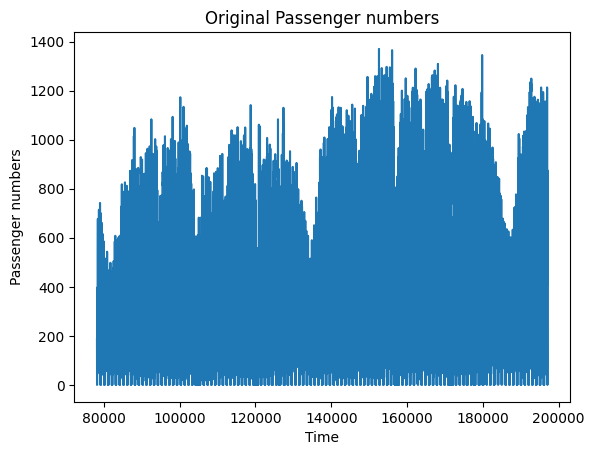

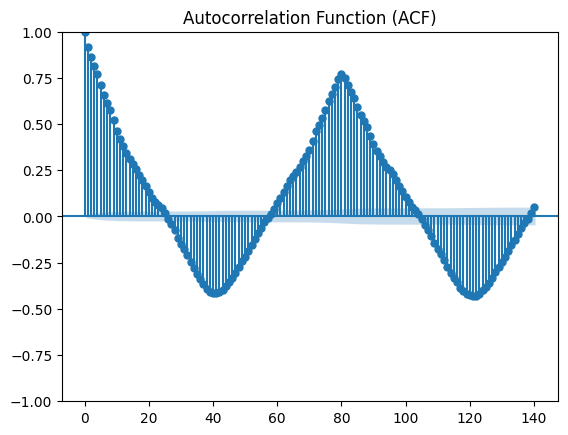

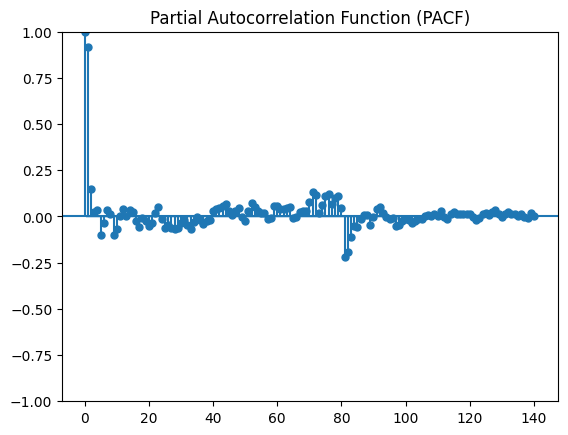

In [15]:
line = "1A"

# Plotting the original time series
plt.plot(df60[(df60["line"] == line)]["passengersBoarding"])
plt.title("Original Passenger numbers")
plt.xlabel("Time")
plt.ylabel("Passenger numbers")

# Plotting ACF (Autocorrelation Function)
plot_acf(df15[(df15["line"] == line)]["passengersBoarding"], lags=140, alpha=0.05)
plt.title("Autocorrelation Function (ACF)")

# Plotting PACF (Partial Autocorrelation Function)
plot_pacf(df15[(df15["line"] == line)]["passengersBoarding"], lags=140, alpha=0.05)
plt.title("Partial Autocorrelation Function (PACF)")

plt.show()

c:\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


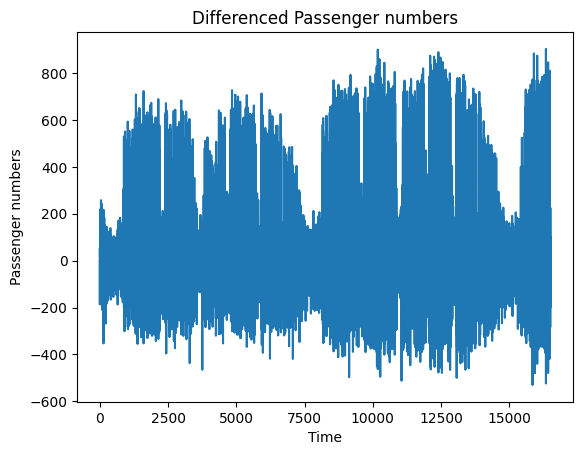

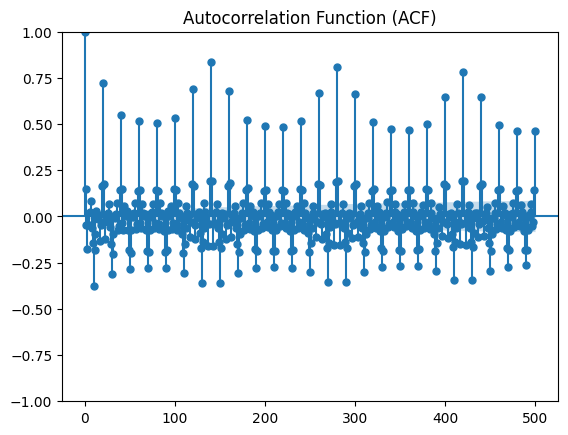

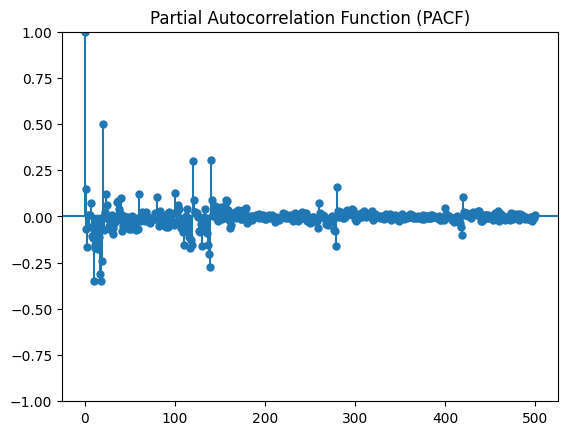

In [16]:
df_subset = df60[df60["line"] == "1A"]
df_subset = df_subset.reset_index(drop=True)
df_subset["diff1"] = df_subset["passengersBoarding"].diff(periods=1).fillna(0)

# Plotting the differenced time series
plt.plot(df_subset["diff1"])
plt.title("Differenced Passenger numbers")
plt.xlabel("Time")
plt.ylabel("Passenger numbers")

# Plotting ACF (Autocorrelation Function)
plot_acf(df_subset["diff1"], lags=500, alpha=0.05)
plt.title("Autocorrelation Function (ACF)")

# Plotting PACF (Partial Autocorrelation Function)
plot_pacf(df_subset["diff1"], lags=500, alpha=0.05)
plt.title("Partial Autocorrelation Function (PACF)")

plt.show()

c:\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


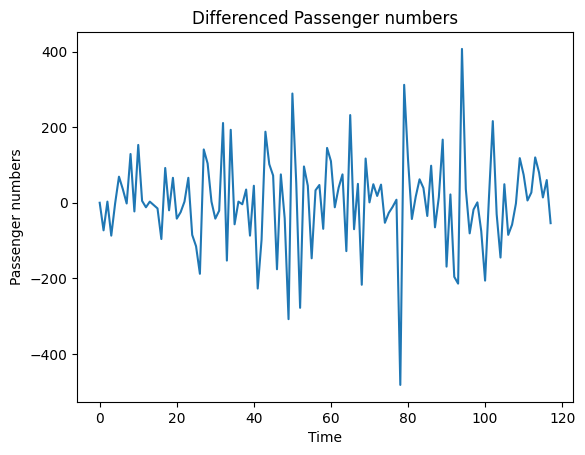

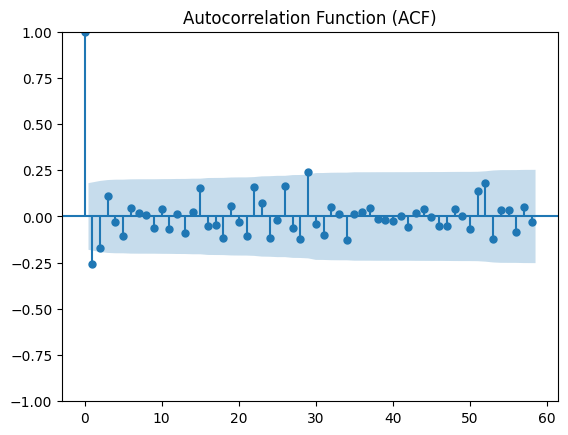

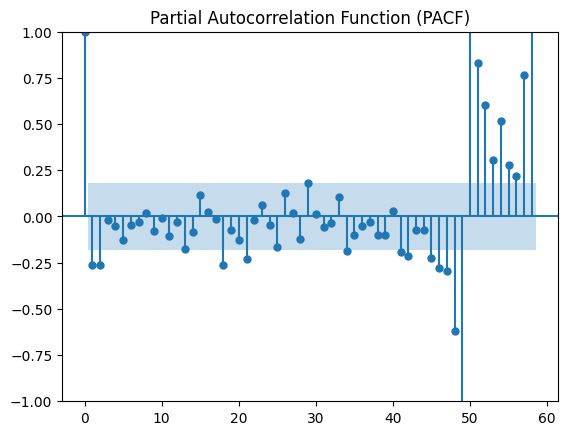

In [32]:
df_subset = df60[(df60["line"] == "5A") & (df60["mon"] == 1) & (df60["hour"] == 16)]
df_subset = df_subset.reset_index(drop=True)
df_subset["diff1"] = df_subset["passengersBoarding"].diff(periods=1).fillna(0)

# Plotting the differenced time series
plt.plot(df_subset["diff1"])
plt.title("Differenced Passenger numbers")
plt.xlabel("Time")
plt.ylabel("Passenger numbers")

# Plotting ACF (Autocorrelation Function)
plot_acf(df_subset["diff1"], lags=58, alpha=0.05)     # ACF measures the correlation between a time series and its own lagged values at different lags.
plt.title("Autocorrelation Function (ACF)")           # We can see that the correlation is insignificant after 2 seasonal lags,
                                                      # and hence weekly dependent after accounting for seasonality.
# Plotting PACF (Partial Autocorrelation Function)
plot_pacf(df_subset["diff1"], lags=58, alpha=0.05)    # PACF measures the correlation between a time series and its own lagged values after removing the contributions of the intermediate lags.
plt.title("Partial Autocorrelation Function (PACF)")  # We can see that there is high correlation between the current observation and 1 year ago,
                                                      # but since it is not viable to include 1 year lags (Low amount of data), it should not be necessary to account for this.
plt.show()